# Sentiment and statistical analysis of the CIA World Factbook
## Does the CIA WFB portray countries differently according to their relations with the US? 

I use different sentiment classification methods to produce the sentiment per country and then combine YouGov survey data (as labels) in order to statistically test the question. The paper can be found https://www.researchgate.net/publication/344516703_Sentiment_Analysis_of_the_CIA_World_Factbook and the CIA World Factbook used in https://github.com/Podipan/cia_world_factbook. The paper-version was based on the 2018 edition of the CIA WFB. The implementation below makes use of the 2019 CIA WFB, hence slight variations of outcomes compared to the original paper.

In [1]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
import pandas as pd
import textblob
import matplotlib.pyplot as plt
import scipy

In [2]:
# Data-set creation
data = pd.read_pickle("v5_CIA_World_Factbook_missing_imputed.pkl") 
for c in data.columns:
    if "txt " not in c:
        data.drop(c, axis="columns", inplace=True)
data.fillna(" ", inplace=True)

In [3]:
# Stop words approached "manually" for better control and interpretability. Consider from nltk.corpus import stopwords
months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october',
      'november', 'december']
extra_words = ["th", "per", "total", "na", "nan", "none", "gdp", "sq", "bbl", "day", "`", "u", "from", '``',"''"]
stop_words = ['i', "to", 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
              "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
              "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
              'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is',
              'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did',
              'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
              'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
              'in', 'on', 'again', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'both', 'each',
              'other', 'some', 'such', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't",
              "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn',
              "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
              "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan',
              "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn',
              "wouldn't"]
stop_words.extend(months)
stop_words.extend(extra_words)

In [4]:
# lambdas used for training purposes, consider applymap()
lemmatizer = WordNetLemmatizer()
great_britain = lambda x: x.replace("great britain", "britain")
composite_words = lambda x: x.replace("-", " ")
removals = lambda x: re.sub("[\[\]\`()$%=:;,.*\d+]", "", x)
tokenizer = lambda x: nltk.word_tokenize(x)
stop_word_removal = lambda x:[w for w in x if not w in stop_words]
lemmatization = lambda x: [lemmatizer.lemmatize(word) for word in x]

for c in data.columns:
    data[c] = data[c].apply(great_britain).apply(composite_words).apply(removals).apply(tokenizer).apply(stop_word_removal).apply(lemmatization)

In [5]:
data.to_excel("Preprocessed.xlsx")
data.to_pickle("Preprocessed.pkl")

In [6]:
corpus = []
for c in data.columns.values:
    for i in data.index.values:
        if data.loc[i,c] != 0:
            corpus.extend(data.loc[i,c])

In [7]:
# Lexicon-Based (& Pattern)
def Text_blob():
    data = pd.read_pickle("Preprocessed.pkl")
    sentiments = []
    sentences = []

    for c in data.columns.values:
        for i in data.index.values:
            if len(data.loc[i, c]) > 0:
                try:
                    sentence = data.loc[i, c]
                    sentence = " ".join(sentence)
                    sentence = textblob.TextBlob(sentence)
                    sentiment = sentence.sentiment.polarity
                    sentiments.append(sentiment)
                    sentences.append(sentence)
                    data.loc[i, c] = sentiment
                except Exception as e:
                    print("ERROR", e)
    sentiments_df = pd.DataFrame({"Text":sentences, "Sentiment":sentiments})
    sentiments_df.sort_values(by=["Sentiment"], ascending=False, inplace=True)
    sentiments_df.to_excel("TextBlob Ranks.xlsx")
    data.to_excel("TextBlob Overall.xlsx")
    
    
def NLTK_Lex():
    import nltk
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    nltk.download('vader_lexicon')
    data = pd.read_pickle("Preprocessed.pkl")
    sentiments = []
    sentences = []

    for c in data.columns.values:
        for i in data.index.values:
            if len(data.loc[i, c]) > 0:

                sentence = data.loc[i, c]
                sentence = " ".join(sentence)
                sentiment = SentimentIntensityAnalyzer().polarity_scores(sentence)["compound"]
                data.loc[i, c] = sentiment
                sentiments.append(sentiment)
                sentences.append(sentence)



    sentiments_df = pd.DataFrame({"Text":sentences, "Sentiment":sentiments})
    sentiments_df.sort_values(by=["Sentiment"], ascending=False, inplace=True)
    sentiments_df.to_excel("NLTK Ranks.xlsx")
    data.to_excel("NLTK Overall.xlsx")

In [8]:
# Deep Learning (LSTM) - Word Embeddings
def FLAIR():
    import flair
    from flair.data import Sentence
    from flair.models import TextClassifier

    flair_sentiment = TextClassifier.load('en-sentiment')
    data = pd.read_pickle("Preprocessed.pkl")
    sentiments = []
    sentences = []

    for c in data.columns.values:
        for i in data.index.values:
            if len(data.loc[i, c]) > 0:
                sentence = data.loc[i, c]
                sentence = " ".join(sentence)
                sent = Sentence(sentence)
                flair_sentiment.predict(sent)
                sentiment = sent.labels

                data.loc[i, c] = sentiment
                sentiments.append(sentiment)
                sentences.append(sentence)

    sentiments_df = pd.DataFrame({"Text": sentences, "Sentiment": sentiments})
    sentiments_df.to_excel("Flair Ranks.xlsx")
    data.to_excel("Flair Overall.xlsx")

In [9]:
# This may take several minutes up to an hour, can be better tuned by avoiding loops inside relative functions
Text_blob()
NLTK_Lex()
FLAIR()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


2020-12-18 22:18:33,165 loading file C:\Users\Lenovo\.flair\models\sentiment-en-mix-distillbert.pt


In [10]:
allies = pd.read_excel("Friends&Allies.xlsx", index_col=0)
data = pd.read_excel("NLTK Overall.xlsx",index_col=0)

list_replace = lambda x: 0 if type(x) == str else x
data = data.applymap(list_replace)

data["Sentiment"] = data.sum(axis=1)
names = pd.read_pickle("v5_CIA_World_Factbook_missing_imputed.pkl")["txt country name"]
combined = data.join(names, lsuffix='_caller', rsuffix='_other')
combined.set_index("txt country name_other", inplace=True)

data = pd.DataFrame(data=combined["Sentiment"], index=combined.index)
data.rename({"korea, north":"north korea", "russia":"russian federation", "gaza strip":"palestine",
                        "korea, south":"the republic of korea (south korea)","congo, democratic republic of the":"the democratic republic of the congo",
                        "congo, republic of the":"congo", "czechia":"czech republic"}, axis="index", inplace=True)

In [11]:
for i in data.index.values:
    if i not in allies.index.values:
        data.drop(i, axis="rows", inplace=True)
data = data.combine_first(allies)
data.dropna(axis="rows", how="any", inplace=True)

In [12]:
for i in data.index.values:
    data.loc[i, "Label"] = data.loc[i, "Label"].strip()
    if data.loc[i, "Label"] == "Ally":
        data.loc[i, "Label_num"] = 2
        data.loc[i, "Color"] = "b"
    elif data.loc[i, "Label"] == "Friendly":
        data.loc[i, "Label_num"] = 1
        data.loc[i, "Color"] = "g"
    elif data.loc[i, "Label"] == "Not sure":
        data.loc[i, "Label_num"] = 0
        data.loc[i, "Color"] = "gray"
    elif data.loc[i, "Label"] == "Unfriendly":
        data.loc[i, "Label_num"] = -1
        data.loc[i, "Color"] = "y"
    elif data.loc[i, "Label"] == "Enemy":
        data.loc[i, "Label_num"] = -2
        data.loc[i, "Color"] = "r"
data.to_excel("combined.xlsx")


temp_df = data[data["Label_num"] != 0]
temp_df = temp_df[temp_df["Label_num"] != -2]
x = temp_df["Label_num"].values.tolist()
y = temp_df["Sentiment"].values.tolist()
print(scipy.stats.pearsonr(x, y), scipy.stats.spearmanr(x, y))

x_ = data["Label_num"].values.tolist()
y_ = data["Sentiment"].values.tolist()
data.to_excel("test.xlsx")

(0.5414863937211514, 1.137551011353549e-05) SpearmanrResult(correlation=0.44227687290345863, pvalue=0.0005088022561804944)


In [13]:
from scipy.stats import spearmanr
from scipy.stats import shapiro
from scipy.stats import kendalltau
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_rel
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import pingouin as pg




print("PEARSON COEFF:",scipy.stats.pearsonr(x_, y_)[0], "p Value:",scipy.stats.pearsonr(x_, y_)[1])
t2, p2 = mannwhitneyu(x_, y_)
print("t = " + str(t2))
print("p = " + str(p2))

assistant = dict()
for i in data["Label"].unique():
    x = data.loc[data['Label'] == i]
    x = x["Sentiment"].values.tolist()
    for il in data["Label"].unique():
        x_ = data.loc[data['Label'] == il, ]
        x_ = x_["Sentiment"].values.tolist()
        leng = min([len(x),len(x_)])
        x_ = x_[:leng]
        x = x[:leng]
        print(len(x), len(x_))
        print(i, il, mannwhitneyu(x, x_))

    #print("FOR:", i, ", VARIANCE:",statistics.variance(x), "STD DEVIATION:",statistics.stdev(x),"SKEWNESS:",scipy.stats.skew(x, bias=False))
    y = i
    assistant[y] = x

PEARSON COEFF: 0.4550577406268459 p Value: 1.2739851666968333e-08
t = 1207.0
p = 6.695547670777861e-39
8 8
Unfriendly Unfriendly MannwhitneyuResult(statistic=32.0, pvalue=0.4789368101108204)
8 8
Unfriendly Not sure MannwhitneyuResult(statistic=16.0, pvalue=0.05178093558826699)
8 8
Unfriendly Friendly MannwhitneyuResult(statistic=6.0, pvalue=0.003702766670250134)
7 7
Unfriendly Ally MannwhitneyuResult(statistic=3.0, pvalue=0.003645179045767819)
4 4
Unfriendly Enemy MannwhitneyuResult(statistic=8.0, pvalue=0.44261695723660077)
8 8
Not sure Unfriendly MannwhitneyuResult(statistic=16.0, pvalue=0.05178093558826699)
8 8
Not sure Not sure MannwhitneyuResult(statistic=32.0, pvalue=0.4789368101108204)
8 8
Not sure Friendly MannwhitneyuResult(statistic=5.0, pvalue=0.0026924700000735156)
7 7
Not sure Ally MannwhitneyuResult(statistic=7.0, pvalue=0.014921032208977135)
4 4
Not sure Enemy MannwhitneyuResult(statistic=6.0, pvalue=0.33250277105101456)
8 8
Friendly Unfriendly MannwhitneyuResult(statist

c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


<function matplotlib.pyplot.show(*args, **kw)>

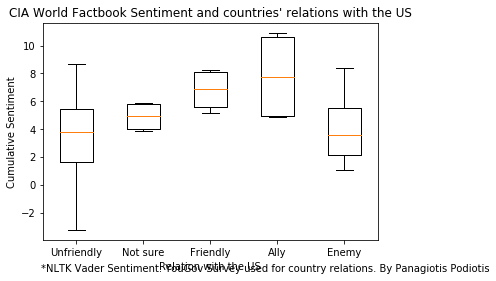

In [14]:
fig, ax = plt.subplots()
ax.boxplot(assistant.values())
ax.set_xticklabels(assistant.keys())
plt.title("CIA World Factbook Sentiment and countries' relations with the US")
plt.xlabel("Relation with the US")
plt.ylabel("Cumulative Sentiment")
text = "*NLTK Vader Sentiment. YouGov Survey used for country relations. By Panagiotis Podiotis"
plt.gcf().text(0.12, 0.015, text, fontsize=10)
#plt.ylim(bottom=0)
#plt.xlim(left=0, right=0)
plt.show